# Simulated Financial Transaction Database Cleaning and Transformation
The following process cleans and transforms the Lopez-Rojas dataset in a couple of important ways:
1. Introduces 24-hour interval timings
2. Summarizes destination account in the frequency domain
3. Splits train (70%), test (20%), and validation (10%)

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Exploration

In [14]:
dataset_filepath = '/Users/tavin/School/csci4622/MLProjectB-T-B-/dataset_raw.csv'

transactions = pd.read_csv(dataset_filepath)

Let's check out this dataset a bit...

In [296]:
transactions.loc[:, 'hourInDay'] = transactions.loc[:, 'step'] % 24
transactions.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hourInDay
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1


In [16]:
name_dest_counts = transactions.value_counts('nameDest')
name_dest_counts.head()

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C1590550415    101
Name: count, dtype: int64

In [301]:
default_dest_to_inspect = 'C1286084959'

def get_transactions_to_dest(dest_to_inspect=default_dest_to_inspect):
    return transactions.loc[transactions['nameDest'] == dest_to_inspect]

In [208]:
def transaction_metrics_by_hour(target):
    def transaction_metrics(x):
        x_legit = x[x['isFraud'] != 1]
        count_legit = len(x_legit.index)
        volume_legit = x_legit['amount'].sum()

        x_fraud = x[x['isFraud'] == 1]
        count_fraud = len(x_fraud.index)
        volume_fraud = x_fraud['amount'].sum()

        count_total = count_legit + count_fraud
        volume_total = volume_legit + volume_fraud

        return pd.Series([count_total, volume_total, count_legit, volume_legit, count_fraud, volume_fraud], index=['transactionCount', 'transactionVolume', 'legitCount', 'legitVolume', 'fraudCount', 'fraudVolume'])

    return target.groupby('hourInDay')[['hourInDay', 'amount', 'isFraud']].apply(transaction_metrics)

In [209]:
def plot_transaction_metrics(transaction_metric, ax, twin_ax, show_labels=True, plot_type='bar'):
    # Axis content is a list[tuple[property_index, property_name, property_offset, property_width, property_color, axis]]
    ax_content = [
        ('transactionCount', '# Transactions', -0.4, 0.2, 'purple', ax),
        ('transactionVolume', '$ Volume', -0.2, 0.2, 'pink', twin_ax),
        ('legitVolume', '$ Legit', 0.2, 0.4, 'green', twin_ax),
        ('fraudVolume', '$ Fraud', 0.2, 0.4, 'red', twin_ax)
    ]

    for property_index, property_name, property_offset, property_width, property_color, axis in ax_content:
        if plot_type == 'bar':
            axis.bar(transaction_metric.index + property_offset, transaction_metric[property_index], width=property_width, color=(property_color, 0.5), label=property_name)
        elif plot_type == 'area':
            axis.fill_between(transaction_metric.index, transaction_metric[property_index], color=(property_color, 0.2), label=property_name)
    
    if show_labels:
        ax.set_ylabel('Count', color='purple')
        ax.set_xlabel('Hour of Day')
        twin_ax.set_ylabel('$ Volume', color='pink')
    
    ax.xaxis.set_ticks(range(0,24,6))

/var/folders/0v/n536_z1j36j_q_1myqms5_m80000gn/T/ipykernel_14381/1321002422.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_to_dest.loc[:, 'hourInDay'] = transactions_to_dest.loc[:, 'step'] % 24
/var/folders/0v/n536_z1j36j_q_1myqms5_m80000gn/T/ipykernel_14381/1321002422.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_to_dest.loc[:, 'hourInDay'] = transactions_to_dest.loc[:, 'step'] % 24
/var/folders/0v/n536_z1j36j_q_1myqms5_m80000gn/T/ipykernel_14381/1321002422.py:5: Settin

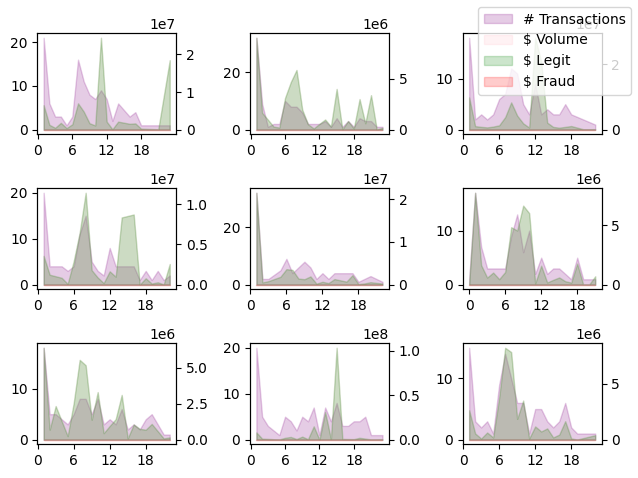

In [210]:
fig, axs = plt.subplots(3, 3)

handles, labels = [], []
for i, ax in np.ndenumerate(axs.ravel()):
    dest_to_inspect = name_dest_counts.index[i[0]]
    dest_for_ax = get_transactions_to_dest(dest_to_inspect=dest_to_inspect)

    twin_ax = ax.twinx()

    plot_transaction_metrics(transaction_metrics_by_hour(dest_for_ax), ax=ax, twin_ax=twin_ax, show_labels=False, plot_type='area')

    if i[0] == 0:
        ax_handles, ax_labels = ax.get_legend_handles_labels()
        twin_ax_handles, twin_ax_labels = twin_ax.get_legend_handles_labels()
        handles = ax_handles + twin_ax_handles
        labels = ax_labels + twin_ax_labels

fig.legend(handles=handles, labels=labels)
fig.tight_layout()

In [321]:
def transaction_metrics_summary(name):
    target = get_transactions_to_dest(dest_to_inspect=name)
    target_legit_mask = (target.isFraud != 1)
    target_time_mean = target.loc[target_legit_mask, 'hourInDay'].mean()
    target_time_std = target.loc[target_legit_mask, 'hourInDay'].std(ddof=0)
    target_amount_mean = target.loc[target_legit_mask, 'amount'].mean()
    target_amount_std = target.loc[target_legit_mask, 'amount'].std(ddof=0)

    return pd.DataFrame.from_dict({name: [target_time_mean, target_time_std, target_amount_mean, target_amount_std]}, columns=['legitTimeMean', 'legitTimeStd', 'legitAmountMean', 'legitAmountStd'], orient='index')

In [324]:
def transaction_metrics_summary_values(name):
    target = get_transactions_to_dest(dest_to_inspect=name)
    target_legit_mask = (target.isFraud != 1)
    target_time_mean = target.loc[target_legit_mask, 'hourInDay'].mean()
    target_time_std = target.loc[target_legit_mask, 'hourInDay'].std(ddof=0)
    target_amount_mean = target.loc[target_legit_mask, 'amount'].mean()
    target_amount_std = target.loc[target_legit_mask, 'amount'].std(ddof=0)

    return [target_time_mean, target_time_std, target_amount_mean, target_amount_std]

In [ ]:
unique_destinations = transactions['nameDest'].unique()
transaction_dest_metrics = pd.DataFrame.from_dict({destination_name: transaction_metrics_summary_values(name=destination_name) for destination_name in unique_destinations},
                                                  columns=['legitTimeMean', 'legitTimeStd', 'legitAmountMean', 'legitAmountStd'],
                                                  orient='index')
# transaction_dest_metrics = pd.concat([transaction_metrics_summary(name=destination_name) for destination_name in unique_destinations])

In [330]:
transaction_dest_metrics

,legitTimeMean,legitTimeStd,legitAmountMean,legitAmountStd
M1979787155,1.000000,0.000000,9.839640e+03,0.000000e+00
M2044282225,1.000000,0.000000,1.864280e+03,0.000000e+00
C553264065,15.093023,4.241621,2.307582e+05,2.502531e+05
C38997010,14.625000,3.374074,4.504258e+05,8.761734e+05
M1230701703,1.000000,0.000000,1.166814e+04,0.000000e+00
...,...,...,...,...
C1282788025,12.600000,5.462600,2.006016e+05,2.150654e+05
C1870252780,10.137500,6.422118,3.308831e+05,3.873830e+05
C97730845,9.281250,5.790983,1.351749e+06,5.005354e+06
C100555887,12.953488,4.655347,4.163992e+05,6.078077e+05
